In [1]:
%load_ext autoreload
%autoreload 2
import argparse
import logging
import os

import numpy as np
import torch
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm

import utils
import model.net as net
import model.data_loader as data_loader
from evaluate import evaluate
from final_metrics import final_metrics
import matplotlib.pyplot as plt






In [2]:
data_dir = '/home/data/FETAL/30_slice_data'
#data_dir = '/home/data/FETAL'
#data_dir= '/home/sbakr/data'
model_dir = 'experiments/base_model'
restore_file = None 

In [3]:
def train(model, optimizer, loss_fn, dataloader, metrics, params, epoch_num):
    """Train the model on `num_steps` batches

    Args:
        model: (torch.nn.Module) the neural network
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches training data
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        num_steps: (int) number of batches to train on, each of size params.batch_size
    """

    # set model to training mode
    model.train()

    # summary for current training loop and a running average object for loss
    summ = []
    all_outputs=[]
    all_labels=[]
    loss_avg = utils.RunningAverage()

    # Use tqdm for progress bar
    with tqdm(total=len(dataloader)) as t:
        for i, (train_batch, labels_batch) in enumerate(dataloader):
            # move to GPU if available
            if params.cuda:
                train_batch, labels_batch = train_batch.cuda(async=True), labels_batch.cuda(async=True)
            # convert to torch Variables
            train_batch, labels_batch = Variable(train_batch), Variable(labels_batch)

            # compute model output and loss
            output_batch = model(train_batch)
            loss = loss_fn(output_batch, labels_batch)

            # clear previous gradients, compute gradients of all variables wrt loss
            optimizer.zero_grad()
            loss.backward()

            # performs updates using calculated gradients
            optimizer.step()

            
            all_labels.append(labels_batch)
            all_outputs.append(output_batch)

            
            # Evaluate summaries only once in a while
            
            if i % params.save_summary_steps == 0:
                #import pdb; pdb.set_trace()
                # extract data from torch Variable, move to cpu, convert to numpy arrays
                output_batch = output_batch.data.cpu().numpy()
                labels_batch = labels_batch.data.cpu().numpy()

                # compute all metrics on this batch
                summary_batch = {metric:metrics[metric](output_batch, labels_batch)
                                 for metric in metrics}
                summary_batch['loss'] = loss.data[0]
                summ.append(summary_batch)

            # update the average loss
            loss_avg.update(loss.data[0])

            t.set_postfix(loss='{:05.3f}'.format(loss_avg()))
            t.update()
            
    #import pdb; pdb.set_trace()
    all_labels=torch.cat(all_labels, 0)
    all_outputs=torch.cat(all_outputs, 0)
    
    
    all_predictions = np.argmax((all_outputs.data).cpu().numpy(), axis=1)
    all_labels=all_labels.data.cpu().numpy()
    
    precision, recall, F1, accuracy= final_metrics(all_predictions, all_labels)
    with open("metric_data.txt", "a") as f:
        f.write("train " + str(epoch_num) + " precision " + str(precision) + "\n")
        f.write("train " + str(epoch_num) + " recall " + str(recall) + "\n")
        f.write("train " + str(epoch_num) + " F1 " + str(F1) + "\n")
        f.write("train " + str(epoch_num) + " accuracy " + str(accuracy) + "\n")
    
    print("precision: %.3f ; recall: %.3f ; F1: %.3f ; accuracy: %.3f" % (precision,recall,F1,accuracy))
    
    
    # compute mean of all metrics in summary
    metrics_mean = {metric:np.mean([x[metric] for x in summ]) for metric in summ[0]}
    metrics_string = " ; ".join("{}: {:05.3f}".format(k, v) for k, v in metrics_mean.items())
    logging.info("- Train metrics: " + metrics_string)



In [4]:
def plot_metrics():

    train = {"accuracy":{}, "precision":{}, "recall":{}, "F1":{}}
    eval = {"accuracy":{}, "precision":{}, "recall":{}, "F1":{}}


    with open("metric_data.txt") as f:
        for lines in f:
            words = lines.split()
            if words[0] == "eval":
                eval[words[2]][words[1]] = words[3]
            elif words[0] == "train":
                train[words[2]][words[1]] = words[3]
            else:
                print("error, a line started with neither train nor eval")

    i = 1
    for keys in eval:
        x = []
        y = []
        x2 = []
        y2 = []
        plt.figure(i)
        plt.ylabel(keys)
        plt.xlabel("Epochs")
        for epochs in eval[keys]:
            x.append(int(epochs))
            y.append(float(train[keys][epochs]))
            x2.append(int(epochs))
            y2.append(float(eval[keys][epochs]))
        plt.plot(x, y)
        plt.plot(x2, y2)
        i += 1
    plt.show()


In [5]:
def train_and_evaluate(model, train_dataloader, val_dataloader, optimizer, loss_fn, metrics, params, model_dir,
                       restore_file=None):
    """Train the model and evaluate every epoch.

    Args:
        model: (torch.nn.Module) the neural network
        train_dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches training data
        val_dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches validation data
        optimizer: (torch.optim) optimizer for parameters of model
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        metrics: (dict) a dictionary of functions that compute a metric using the output and labels of each batch
        params: (Params) hyperparameters
        model_dir: (string) directory containing config, weights and log
        restore_file: (string) optional- name of file to restore from (without its extension .pth.tar)
    """
    # reload weights from restore_file if specified
    if restore_file is not None:
        restore_path = os.path.join(model_dir, restore_file + '.pth.tar')
        logging.info("Restoring parameters from {}".format(restore_path))
        utils.load_checkpoint(restore_path, model, optimizer)

    best_val_acc = 0.0

    for epoch in range(params.num_epochs):
        # Run one epoch
        logging.info("Epoch {}/{}".format(epoch + 1, params.num_epochs))

        # compute number of batches in one epoch (one full pass over the training set)
        train(model, optimizer, loss_fn, train_dataloader, metrics, params, epoch)

        # Evaluate for one epoch on validation set
        val_metrics,precision, recall,F1,accuracy = evaluate(model, loss_fn, val_dataloader, metrics, params)
        
        with open("metric_data.txt", "a") as f:
            f.write("eval " + str(epoch) + " precision " + str(precision) + "\n")
            f.write("eval " + str(epoch) + " recall " + str(recall) + "\n")
            f.write("eval " + str(epoch) + " F1 " + str(F1) + "\n")
            f.write("eval " + str(epoch) + " accuracy " + str(accuracy) + "\n")
        
        val_acc = val_metrics['accuracy']
        is_best = val_acc>=best_val_acc
        

        print("precision: %.3f ; recall: %.3f ; F1: %.3f ; accuracy: %.3f" % (precision,recall,F1,accuracy))
        plot_metrics()
        # Save weights
        utils.save_checkpoint({'epoch': epoch + 1,
                               'state_dict': model.state_dict(),
                               'optim_dict' : optimizer.state_dict()},
                               is_best=is_best,
                               checkpoint=model_dir)

        # If best_eval, best_save_path
        if is_best:
            logging.info("- Found new best accuracy")
            best_val_acc = val_acc

            # Save best val metrics in a json file in the model directory
            best_json_path = os.path.join(model_dir, "metrics_val_best_weights.json")
            utils.save_dict_to_json(val_metrics, best_json_path)

        # Save latest val metrics in a json file in the model directory
        last_json_path = os.path.join(model_dir, "metrics_val_last_weights.json")
        utils.save_dict_to_json(val_metrics, last_json_path)



Loading the datasets...
- done.
Starting training for 1000 epoch(s)
Epoch 1/1000
100%|██████████| 352/352 [07:12<00:00,  1.11s/it, loss=0.391]
- Train metrics: accuracy: 0.719 ; Confusion_Matrix: 0.719 ; loss: 0.309


precision: 0.397 ; recall: 0.040 ; F1: 0.073 ; accuracy: 0.739


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 3.885


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


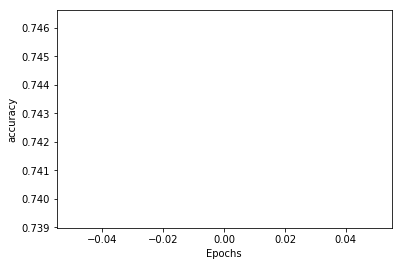

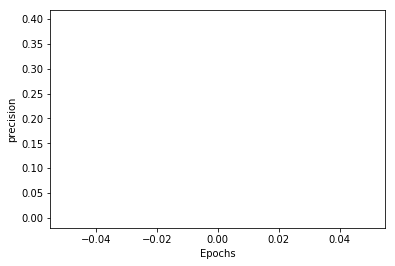

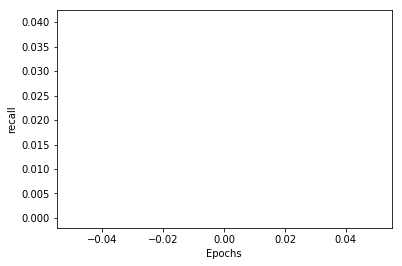

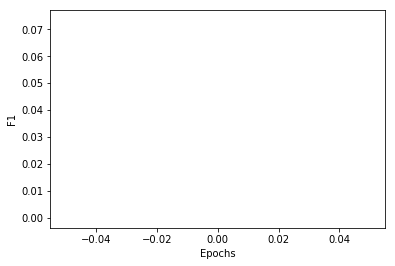

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 2/1000
100%|██████████| 352/352 [07:05<00:00,  1.24s/it, loss=0.357]
- Train metrics: accuracy: 0.750 ; Confusion_Matrix: 0.750 ; loss: 0.370


precision: 0.500 ; recall: 0.001 ; F1: 0.003 ; accuracy: 0.745


- Eval metrics : accuracy: 0.310 ; Confusion_Matrix: 0.310 ; loss: 8.516


precision: 0.258 ; recall: 0.922 ; F1: 0.403 ; accuracy: 0.307


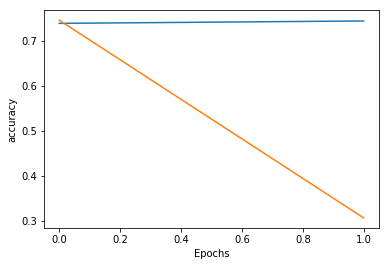

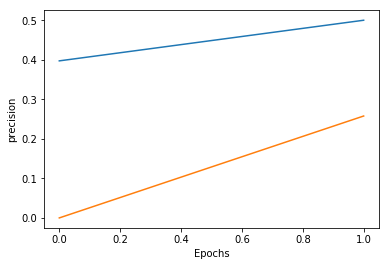

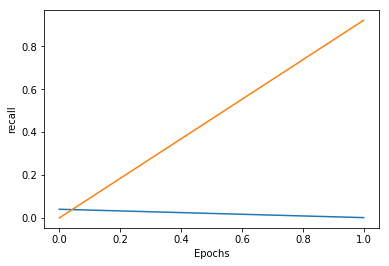

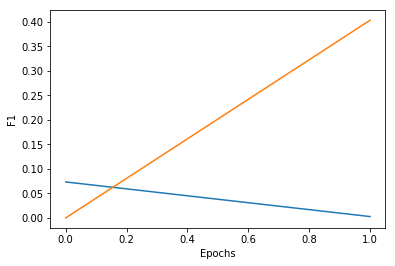

Epoch 3/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [07:06<00:00,  1.23s/it, loss=0.357]
- Train metrics: accuracy: 0.750 ; Confusion_Matrix: 0.750 ; loss: 0.378


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.399 ; Confusion_Matrix: 0.399 ; loss: 5.750


precision: 0.254 ; recall: 0.712 ; F1: 0.375 ; accuracy: 0.396


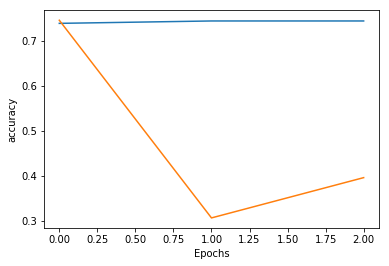

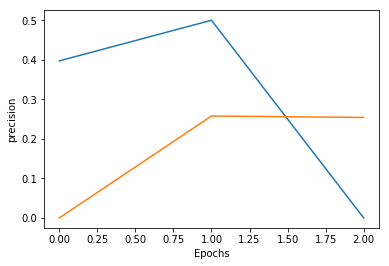

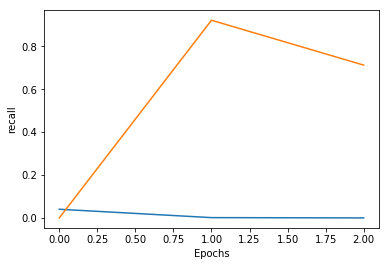

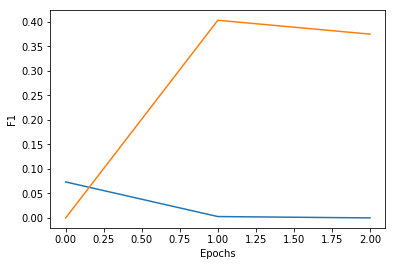

Epoch 4/1000
  0%|          | 0/352 [00:00<?, ?it/s]

Checkpoint Directory exists! 


100%|██████████| 352/352 [07:01<00:00,  1.16s/it, loss=0.358]
- Train metrics: accuracy: 0.906 ; Confusion_Matrix: 0.906 ; loss: 0.198


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 33.582


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


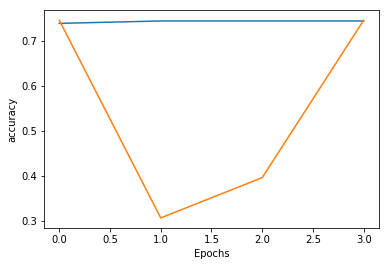

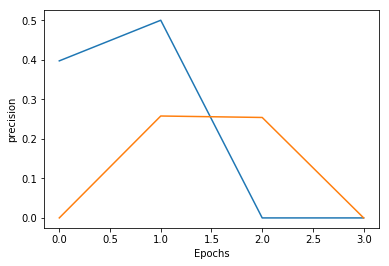

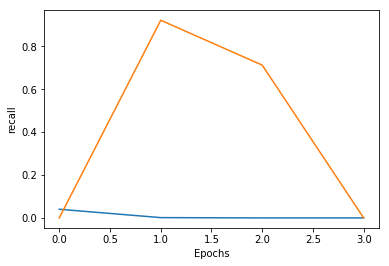

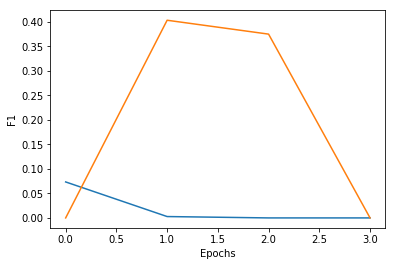

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 5/1000
100%|██████████| 352/352 [07:08<00:00,  1.34s/it, loss=0.356]
- Train metrics: accuracy: 0.750 ; Confusion_Matrix: 0.750 ; loss: 0.336


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 10.185


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


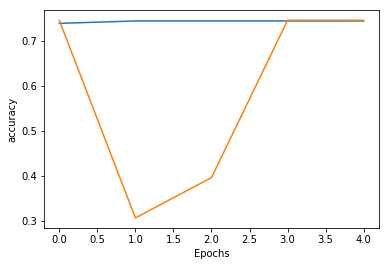

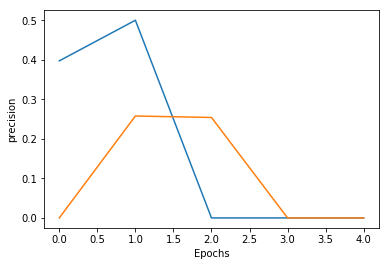

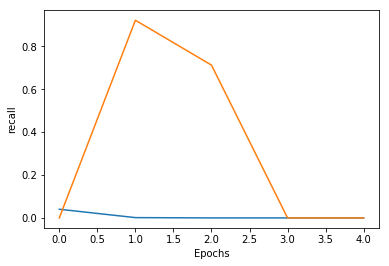

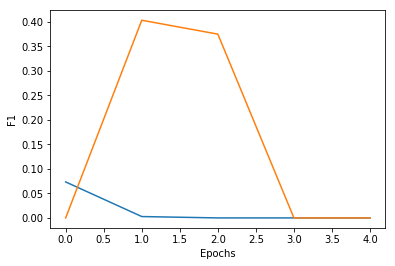

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 6/1000
100%|██████████| 352/352 [07:08<00:00,  1.23s/it, loss=0.359]
- Train metrics: accuracy: 0.875 ; Confusion_Matrix: 0.875 ; loss: 0.215


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 0.819


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


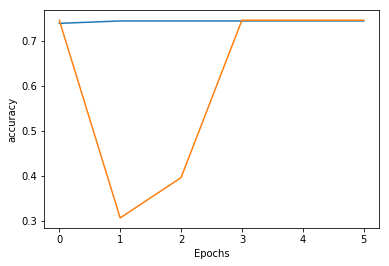

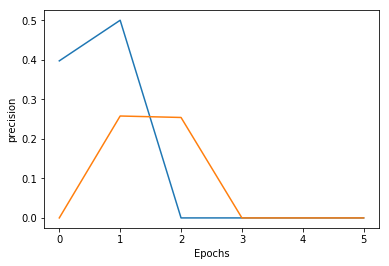

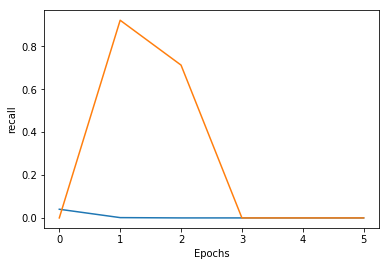

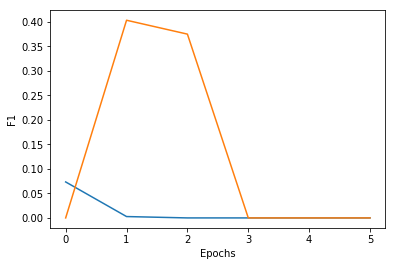

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 7/1000
100%|██████████| 352/352 [06:29<00:00,  1.06s/it, loss=0.351]
- Train metrics: accuracy: 0.750 ; Confusion_Matrix: 0.750 ; loss: 0.333


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.744


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 9.861


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


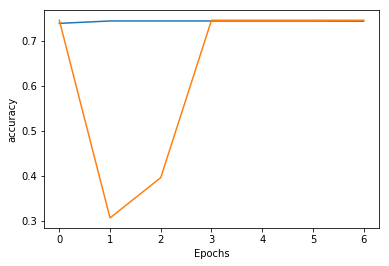

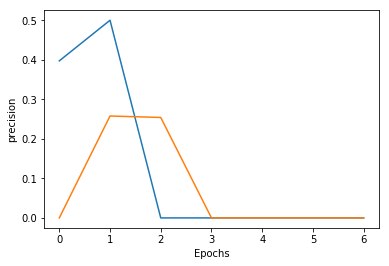

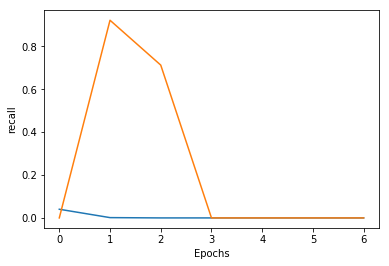

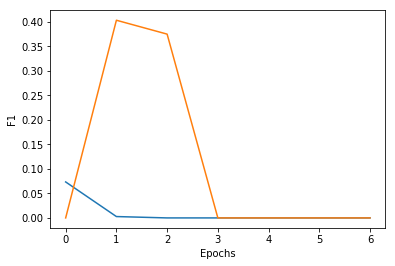

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 8/1000
100%|██████████| 352/352 [06:49<00:00,  1.18s/it, loss=0.349]
- Train metrics: accuracy: 0.844 ; Confusion_Matrix: 0.844 ; loss: 0.252


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 0.419


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


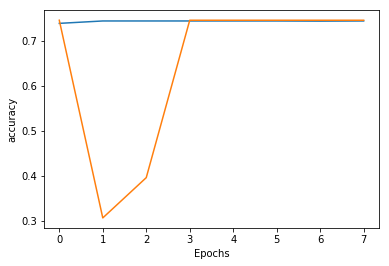

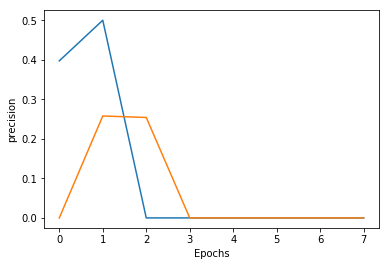

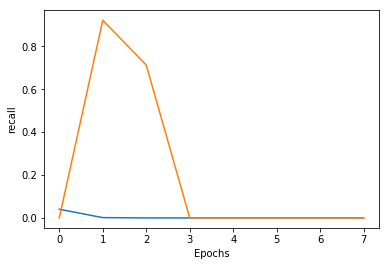

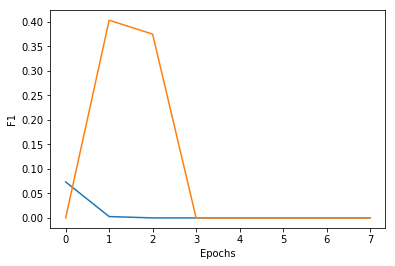

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 9/1000
100%|██████████| 352/352 [06:31<00:00,  1.06s/it, loss=0.354]
- Train metrics: accuracy: 0.812 ; Confusion_Matrix: 0.812 ; loss: 0.266


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 36.174


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


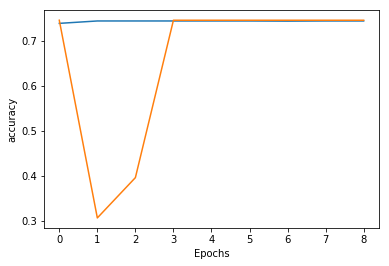

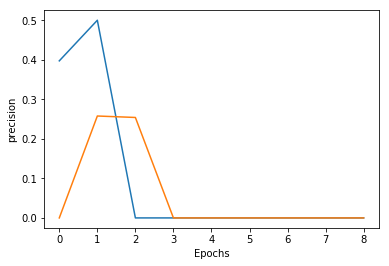

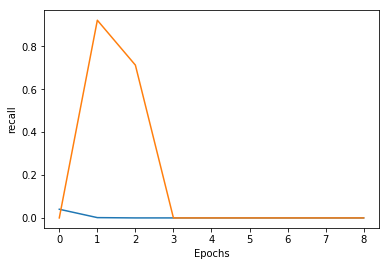

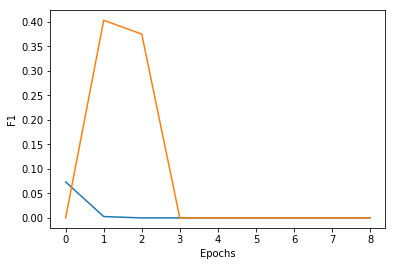

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 10/1000
100%|██████████| 352/352 [07:07<00:00,  1.19s/it, loss=0.353]
- Train metrics: accuracy: 0.719 ; Confusion_Matrix: 0.719 ; loss: 0.387


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 3.008


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


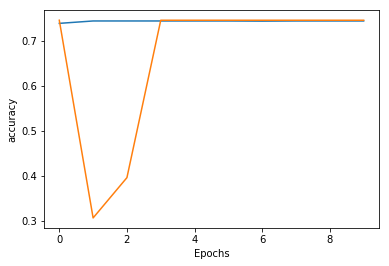

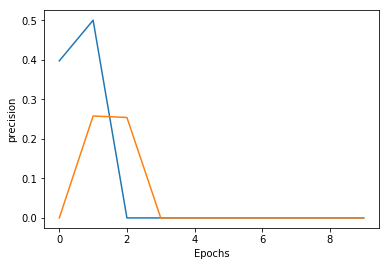

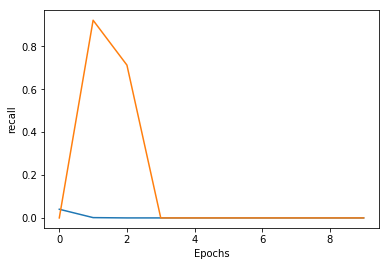

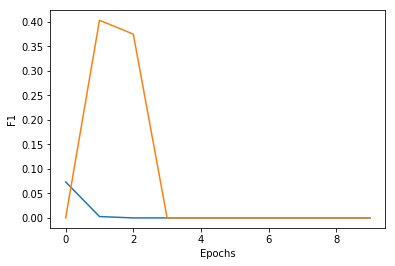

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 11/1000
100%|██████████| 352/352 [07:12<00:00,  1.20s/it, loss=0.353]
- Train metrics: accuracy: 0.812 ; Confusion_Matrix: 0.812 ; loss: 0.276


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 0.363


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


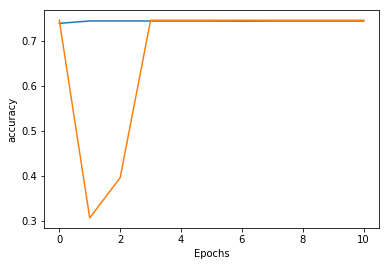

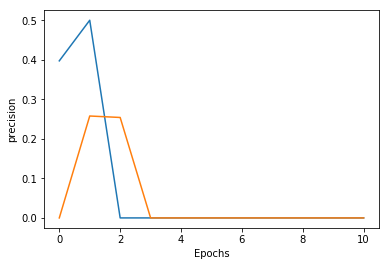

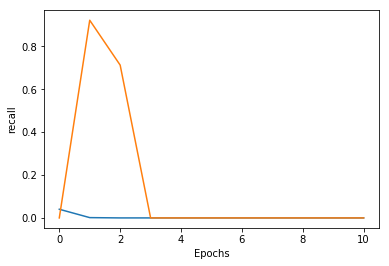

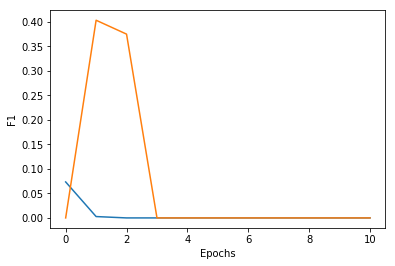

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 12/1000
100%|██████████| 352/352 [07:07<00:00,  1.17s/it, loss=0.353]
- Train metrics: accuracy: 0.750 ; Confusion_Matrix: 0.750 ; loss: 0.349


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 6.696


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


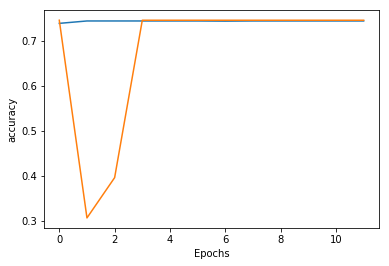

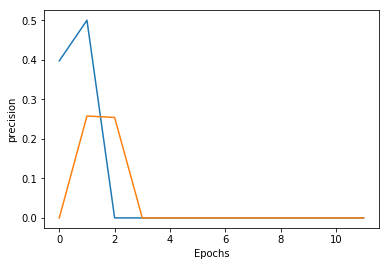

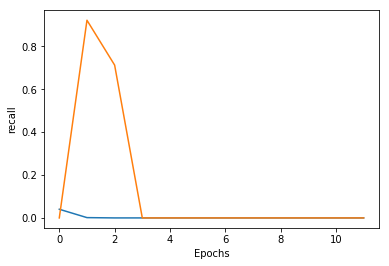

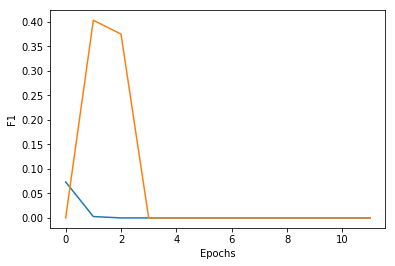

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 13/1000
100%|██████████| 352/352 [07:04<00:00,  1.33s/it, loss=0.356]
- Train metrics: accuracy: 0.656 ; Confusion_Matrix: 0.656 ; loss: 0.483


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 1.088


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


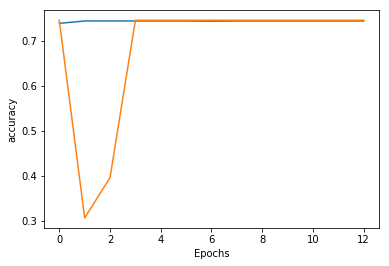

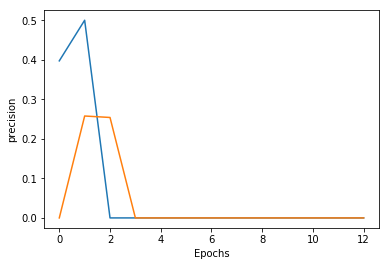

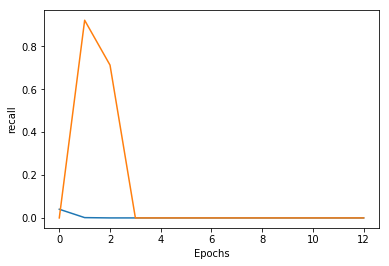

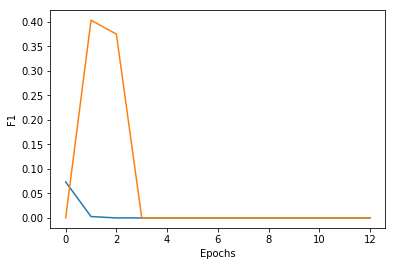

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 14/1000
100%|██████████| 352/352 [07:02<00:00,  1.25s/it, loss=0.354]
- Train metrics: accuracy: 0.719 ; Confusion_Matrix: 0.719 ; loss: 0.401


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


- Eval metrics : accuracy: 0.743 ; Confusion_Matrix: 0.743 ; loss: 39.582


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.746


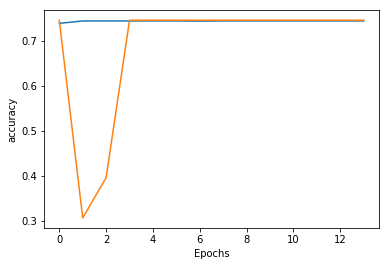

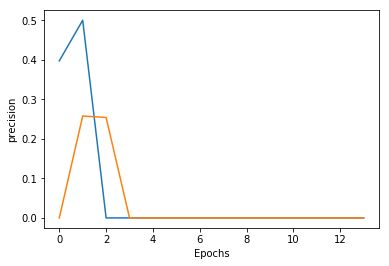

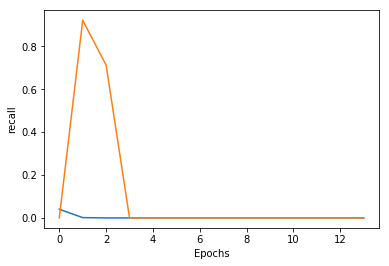

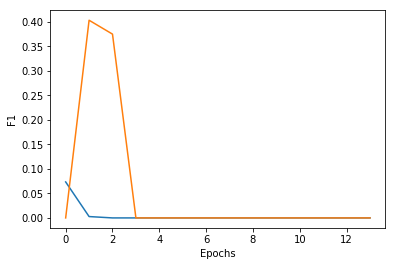

Checkpoint Directory exists! 


- Found new best accuracy
Epoch 15/1000
100%|██████████| 352/352 [06:47<00:00,  1.16s/it, loss=0.349]
- Train metrics: accuracy: 0.750 ; Confusion_Matrix: 0.750 ; loss: 0.337


precision: 0.000 ; recall: 0.000 ; F1: 0.000 ; accuracy: 0.745


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
json_path = os.path.join(model_dir, 'params.json')
assert os.path.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = utils.Params(json_path)

# use GPU if available
params.cuda = torch.cuda.is_available()

# Set the random seed for reproducible experiments
torch.manual_seed(230)
if params.cuda: torch.cuda.manual_seed(230)

# Set the logger
utils.set_logger(os.path.join(model_dir, 'train.log'))

# Create the input data pipeline
logging.info("Loading the datasets...")

# fetch dataloaders
dataloaders = data_loader.fetch_dataloader(['train', 'val'], data_dir, params)
train_dl = dataloaders['train']
val_dl = dataloaders['val']

logging.info("- done.")

# Define the model and optimizer
model = net.Net(params).cuda() if params.cuda else net.Net(params)
optimizer = optim.Adam(model.parameters(), lr=params.learning_rate)

# fetch loss function and metrics
loss_fn = net.loss_fn
metrics = net.metrics

# Train the model
logging.info("Starting training for {} epoch(s)".format(params.num_epochs))
train_and_evaluate(model, train_dl, val_dl, optimizer, loss_fn, metrics, params, model_dir,
                       restore_file)
